# Election Donations

Imports for project

In [2]:
!pip install seaborn
!pip install statsmodels
!pip install nbconvert


In [9]:
import sqlite3
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Combined all the data into a csv and printed a preview of what it looks like

Data Wrangling: Create a unique data set by transforming and combining multiple existing sources of
data into a cohesive whole. Must involve a non-trivial amount of code to manipulate
data into something usable for analysis.

In [10]:
columns = [
    "CAND_ID", "CAND_NAME", "CAND_ICI", "PTY_CD", "CAND_PTY_AFFILIATION", 
    "TTL_RECEIPTS", "TRANS_FROM_AUTH", "TTL_DISB", "TRANS_TO_AUTH", 
    "COH_BOP", "COH_COP", "CAND_CONTRIB", "CAND_LOANS", "OTHER_LOANS", 
    "CAND_LOAN_REPAY", "OTHER_LOAN_REPAY", "DEBTS_OWED_BY", "TTL_INDIV_CONTRIB", 
    "CAND_OFFICE_ST", "CAND_OFFICE_DISTRICT", "SPEC_ELECTION", "PRIM_ELECTION", 
    "RUN_ELECTION", "GEN_ELECTION", "GEN_ELECTION_PRECENT", "OTHER_POL_CMTE_CONTRIB", 
    "POL_PTY_CONTRIB", "CVG_END_DT", "INDIV_REFUNDS", "CMTE_REFUNDS"
]

# This renames all the columns because it didn't have names 
# before and then made it all inot a combined datset
file_paths = glob.glob("weball*.txt")
all_data = []
for file in file_paths:
    data = pd.read_csv(file, delimiter="|", header=None, names=columns, dtype=str)
    all_data.append(data)
final = pd.concat(all_data, ignore_index=True)
final.to_csv("combined_data.csv", index=False)


### Plot showing the distribution of funds being given each year to the election

As seen in the plot, there seems to be a trend of increasing funds given to campaigns as years progress. It spiked drastically during the 2020 election while Donald Trump and Joe Biden were running against one another. 

/var/folders/8_/s9gw06c924vfhj5zhljfk8mw0000gn/T/ipykernel_68038/3925597608.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("combined_data.csv")


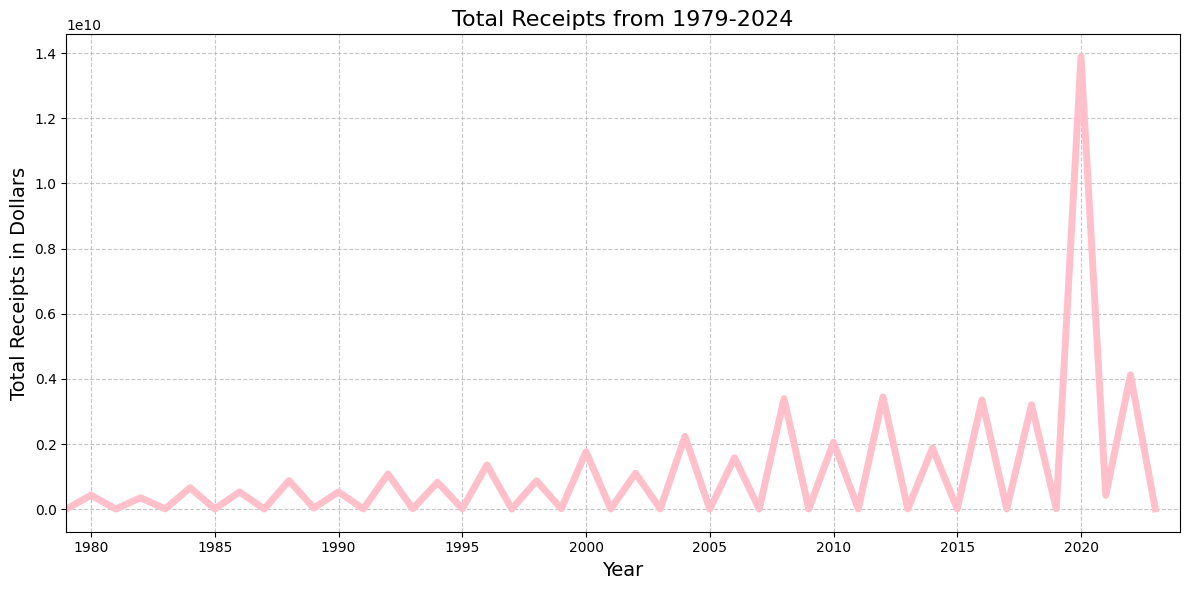

In [11]:
#using the combined data and grouping nessesary columns
#we also made sure that the values aren't null or any na
data = pd.read_csv("combined_data.csv")
data["Year"] = pd.to_datetime(data["CVG_END_DT"], errors="coerce").dt.year
data = data[(data["Year"].notnull()) & (data["TTL_RECEIPTS"].notnull())]
data["Year"] = data["Year"].astype(int)
grouped = (
    data.groupby(["Year", "CAND_PTY_AFFILIATION", "CAND_ICI"])["TTL_RECEIPTS"]
    .sum()
    .reset_index()
)
#making a plot showing the distribution of funds and making sure it was able to be in range
receipts = data.groupby("Year")["TTL_RECEIPTS"].sum().reset_index()
years = pd.DataFrame({"Year": range(1979, 2024)})
receipts = years.merge(receipts, on="Year", how="left").fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=receipts, x="Year", y="TTL_RECEIPTS", linewidth=5, color="pink")
plt.title("Total Receipts from 1979-2024", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Receipts in Dollars", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(1979, 2024)
plt.tight_layout()
plt.show()

### Plot of DEM vs REP in terms of funding for the campaign 

In the 1980s until the 2000s there seemed to be smaller funds given to campaigns but as we see in the later 2000s, more funds are given to democratic campaigns. In the 2020 campaigns with Trump vs Biden, the democratic party seemed to have much more funding and funding spiked significantly high that year that in 2021, Biden won the presidency. 

#task:Statistical Associations
Identify statistical associations found in your data, showing quantitative and visual proof
of the relationships between variables. Discuss the meanings of these associations

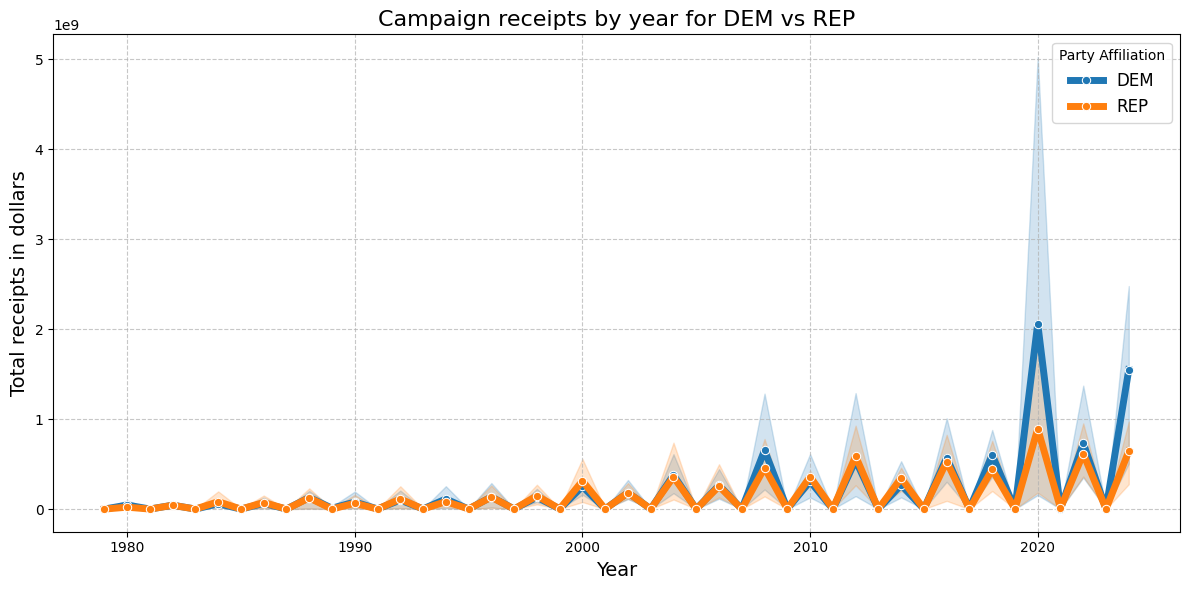

In [12]:
data2 = grouped[
    (grouped["CAND_PTY_AFFILIATION"].isin(["DEM", "REP"])) & 
    (grouped["CAND_ICI"].notnull())
]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data2,
    x="Year",
    y="TTL_RECEIPTS",
    hue="CAND_PTY_AFFILIATION",
    marker="o",
    linewidth=5,
    palette="tab10"
)
plt.title("Campaign receipts by year for DEM vs REP", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total receipts in dollars", fontsize=14)
plt.legend(title="Party Affiliation", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



### Plot of Candidate Status

I= Incumbent, candidate holds the office they are running for. 

C= Challenger, candidate running against incumbent

O= Open Seat, candident running where there is no incumbent

It is seen that incumbents raised more funds but around 2026, challengers and incuments funds have spiked. Most of these spikes happen during times of election years and open seat candidates raise the least money it seems.

#task:Visualization
Create a series of plots that bring some aspect of your data set into specific relief. The
types of plots you use should be determined by what you want to convey, and what
questions you hope to answer.

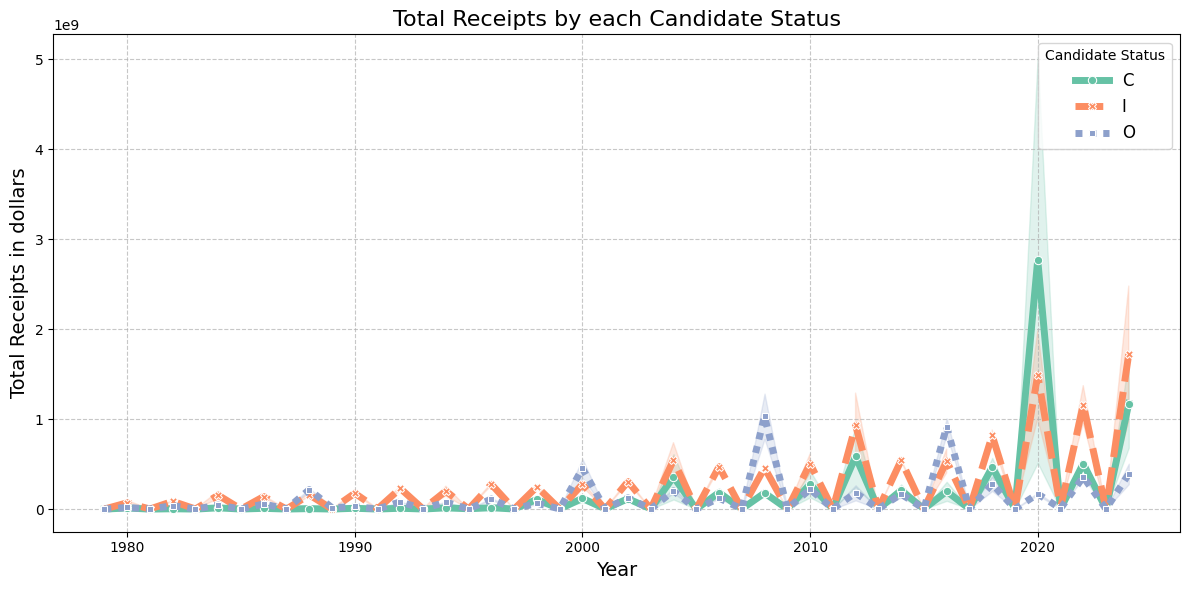

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data2,
    x="Year",
    y="TTL_RECEIPTS",
    hue="CAND_ICI",
    style="CAND_ICI",
    markers=True,
    linewidth=5,
    palette="Set2"
)
plt.title("Total Receipts by each Candidate Status", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Receipts in dollars", fontsize=14)
plt.legend(title="Candidate Status", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Spearmen correlation of wins and losses from funds raised elections

There seems to be a moderate correlation (0.52) between TTL_RECEIPTS (money raised) and election wins and the p-value being 0.0 indicates that there is a statistical signficance. This might not be able to predict the dataset that accurately but it seems fairly good at predicting it since the precision for 0=0.63 and 1= 0.76 and the accuracy is 0.68.

#task: Predictive Modeling
Build a classifier (or regressor) to predict some feature of your data using scikit-learn.
Include a performance analysis, along with any explanation of modeling choices you
made (e.g., model types, parameter values for the models, attributes included or
excluded).

Spearman: 0.5250639494317515, p-val: 0.0
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      2258
           1       0.52      1.00      0.69      2419

    accuracy                           0.53      4677
   macro avg       0.76      0.51      0.36      4677
weighted avg       0.75      0.53      0.37      4677



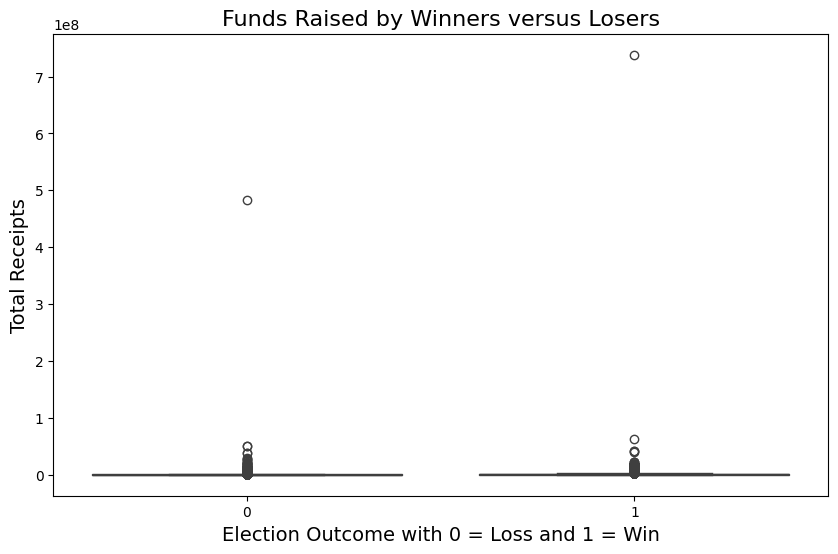

In [14]:
#looks at the specific wins and losses for each election
election = data[data["GEN_ELECTION"].notnull()]
election = election[
    (election["TTL_RECEIPTS"].notnull()) & 
    (election["GEN_ELECTION_PRECENT"].notnull())
]

correlation, p_value = spearmanr(election["TTL_RECEIPTS"], election["GEN_ELECTION_PRECENT"])
print(f"Spearman: {correlation}, p-val: {p_value}")
election["Win"] = election["GEN_ELECTION"].apply(lambda x: 1 if x == "W" else 0)

X = election[["TTL_RECEIPTS"]]
y = election["Win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#also uses log regression here
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.boxplot(x="Win", y="TTL_RECEIPTS", data=election)
plt.title("Funds Raised by Winners versus Losers", fontsize=16)
plt.xlabel("Election Outcome with 0 = Loss and 1 = Win", fontsize=14)
plt.ylabel("Total Receipts", fontsize=14)
plt.show()

### Database using SQL of money raised by state for each year for DEM vs REP

Dem= blue
Rep= orange

#task: Databases
Programmatically store and query your data using a relational database. While we
focused on reading from RDBMSs, you may elect to set up a SQLite database using
CREATE TABLE statements and loading in your data. Once your data is loaded, you
can demonstrate the use of queries to answer questions, summarize, or understand the
data set.

/var/folders/8_/s9gw06c924vfhj5zhljfk8mw0000gn/T/ipykernel_68038/2935576997.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv("combined_data.csv")


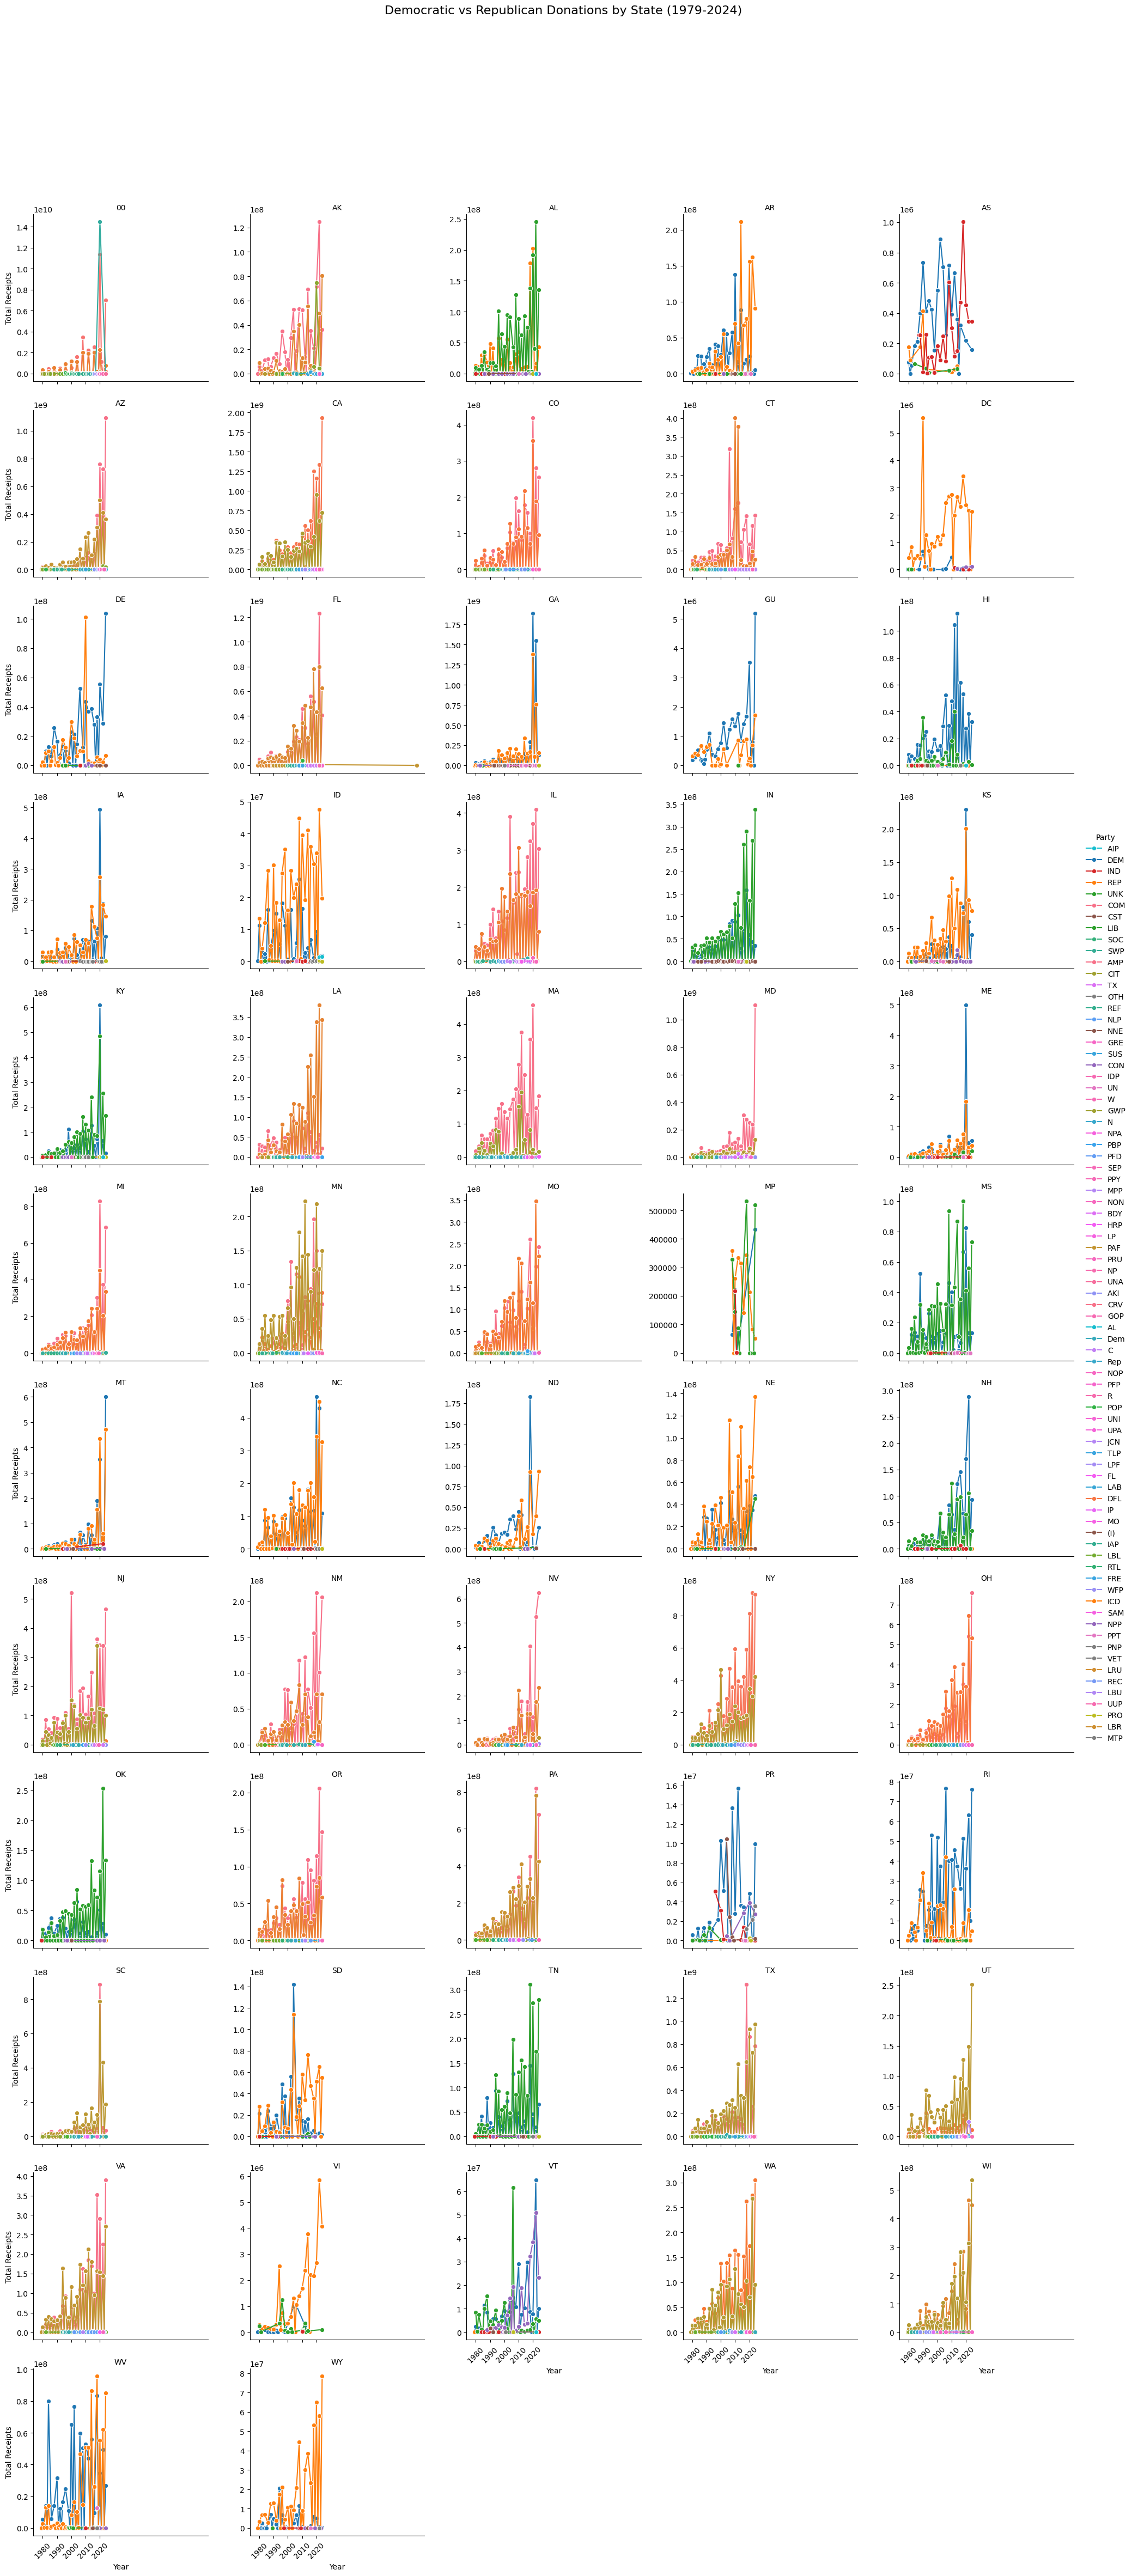

In [15]:
data3 = pd.read_csv("combined_data.csv")
data3["Year"] = pd.to_datetime(data["CVG_END_DT"], errors="coerce").dt.year

data3 = data3[
    (data["Year"] >= 1979) & 
    (data["Year"] <= 2024) & 
    (data["CAND_PTY_AFFILIATION"].isin(["DEM", "REP"]))
]
data3 = data3[data3["CAND_OFFICE_ST"] != "00"]
conn = sqlite3.connect("campaign_data_dem_rep.db")
cursor = conn.cursor()
cursor.execute("""
CREATE TABLE IF NOT EXISTS campaign_funds (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    state TEXT,
    year INTEGER,
    party TEXT,
    total_receipts REAL
)
""")
conn.commit()


records = data[["CAND_OFFICE_ST", "Year", "CAND_PTY_AFFILIATION", "TTL_RECEIPTS"]].values.tolist()
cursor.executemany("""
INSERT INTO campaign_funds (state, year, party, total_receipts)
VALUES (?, ?, ?, ?)
""", records)
conn.commit()


query = """
SELECT state, year, party, SUM(total_receipts) as total
FROM campaign_funds
GROUP BY state, year, party
ORDER BY state, year, party
"""
result = pd.read_sql_query(query, conn)
conn.close()


g = sns.FacetGrid(result, col="state", col_wrap=5, height=4, sharey=False)
g.map_dataframe(
    sns.lineplot, 
    x="year", 
    y="total", 
    hue="party", 
    marker="o"
)
g.add_legend(title="Party")
g.set_axis_labels("Year", "Total Receipts")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Democratic vs Republican Donations by State (1979-2024)", fontsize=16)

for ax in g.axes.flat:
    ax.set_xticks(range(1980, 2025, 10))
    ax.tick_params(axis="x", rotation=45)

plt.show()

# Summary stats

Candidates with high receipts are the Working Families Party (W) which seemed to raised $792,237 at the highest and $233,034 at the lowest. The Working class families are a smaller party. You also see Challenger in the Incumbent category raises exactly $173,270. I and C are bigger parties. When looking into Democratic vs Republican candidates there is likely more uniformity in fundraising like in incumbents and challengers compared to smaller parties since individual candidates might have big fundrasing but it's not as consistant as big parties.

#task: Statistical Summarization
Summarize and explain particular aspects of your data using summary statistics or other
calculations. Simply reporting on means or modes is not enough, you must instead seek
to identify and quantify interesting findings in your data set as a whole or particular
subpopulations.

In [16]:
summary = data.groupby(["CAND_PTY_AFFILIATION", "CAND_ICI"])["TTL_RECEIPTS"].describe()
mean = data.groupby(["CAND_PTY_AFFILIATION", "CAND_ICI"])["TTL_RECEIPTS"].mean()
median = data.groupby(["CAND_PTY_AFFILIATION", "CAND_ICI"])["TTL_RECEIPTS"].median()
std = data.groupby(["CAND_PTY_AFFILIATION", "CAND_ICI"])["TTL_RECEIPTS"].std()

print("Descriptive stat:")
print(summary)
print("\nMean receipts by party:")
print(mean)
print("\nMedian receipts by party:")
print(median)
print("\nSD of receipts by Party:")
print(std)

Descriptive stat:
                               count           mean            std        min  \
CAND_PTY_AFFILIATION CAND_ICI                                                   
(I)                  C           1.0  173270.230000            NaN  173270.23   
AIP                  C           6.0    2705.000000    4119.086064       0.00   
                     O           4.0    5900.345000    6403.429410     115.00   
AKI                  C           1.0      70.760000            NaN      70.76   
AL                   O           1.0   35028.560000            NaN   35028.56   
...                              ...            ...            ...        ...   
UUP                  C           1.0    8484.540000            NaN    8484.54   
VET                  C           1.0     655.470000            NaN     655.47   
W                    C          30.0  159895.674333  792237.889142       0.00   
                     O          12.0   28534.935833   75805.074297       0.00   
WFP       